# Notebook for exercise 2

## 0. Get data ready

In [30]:
# Import the necessary libraries
import os   #helps me erase a warning that i am getting
import numpy as np  #the data are numpy when i first get them
from sklearn.preprocessing import StandardScaler  #need this for standardizing the data
from sklearn.decomposition import PCA #need this for the PCA in the data
import torch
from torch import nn #need this for my model (layers, loss functions, ...)
from sklearn.metrics import accuracy_score #need this to measure the accuracy of the model
import time  #need this to calcualate the training time
from pathlib import Path #need this for the save_model(). 
import matplotlib.pyplot as plt  # need this for the model's plots
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import RandomizedSearchCV


os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # This line erases a warning that i am getting

file_names = []
files = []
#create X_train, y_train, X_test, y_test
X_train = np.full((50000,3072),0,dtype=int)
X_test = np.full((10000,3072),0,dtype=int)
y_train = np.full((50000,),0,dtype=int)
y_test = np.full((10000,),0,dtype=int)

# the unpickle() function loads the CIFAR-10 data from the file
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Creating a list with the names of the files
for i in range(1,6):
    file = f"data_batch_{i}"
    file_names.append(file)
file_names.append("test_batch")

#storing the unpickled dictionaries to a list
for file in file_names:
    cifar10_dict = unpickle(file)
    files.append(cifar10_dict)

# Splitting the data to train and test set
# Printing the shapes to make sure that everything went well
i=0
for file in files:
    print(f"Append: {file[b'batch_label']}")
    if file[b'batch_label'] != b'testing batch 1 of 1':
        #this is the X_train, y_train
        X_train[i*10000:(i+1)*10000,:] = file[b'data']
        y_train[i*10000:(i+1)*10000] = file[b'labels'] 
        i+=1
       
    else:
        #i have just finished X_train, y_train   
        #this is the X_test, y_test
        X_test[:,:] = file[b'data']
        y_test[:] = file[b'labels']
        print(f"Shape X_train: {X_train.shape}\nShape y_train: {y_train.shape}")
        print(f"Shape X_test: {X_test.shape}\nShape y_test: {y_test.shape}\n")
        
        
    

Append: b'training batch 1 of 5'
Append: b'training batch 2 of 5'
Append: b'training batch 3 of 5'
Append: b'training batch 4 of 5'
Append: b'training batch 5 of 5'
Append: b'testing batch 1 of 1'
Shape X_train: (50000, 3072)
Shape y_train: (50000,)
Shape X_test: (10000, 3072)
Shape y_test: (10000,)



In [3]:
pca = PCA(n_components = 0.92)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

scaler = StandardScaler()
X_train_sc_pca = scaler.fit_transform(X_train_pca)
X_test_sc_pca = scaler.transform(X_test_pca)

print(f"X_train_sc_pca.shape = {X_train_sc_pca.shape}")
print(f"X_test_sc_pca.shape = {X_test_sc_pca.shape}")


X_train_sc_pca.shape = (50000, 131)
X_test_sc_pca.shape = (10000, 131)


In [4]:
y_train2 = []
X_train2 = []
y_test2 = []
X_test2 = []

#For training
for idx,value in enumerate(y_train):
    if value == 0 or value == 1:
        y_train2.append(value)
        X_train2.append(X_train[idx,:])

X_train2=np.array(X_train2)
y_train2=np.array(y_train2)

#For testing 
for idx,value in enumerate(y_test):
    if value == 0 or value == 1:
        y_test2.append(value)
        X_test2.append(X_test[idx,:])

X_test2=np.array(X_test2)
y_test2=np.array(y_test2)




print(f"X_train2.shape = {X_train2.shape}")
print(f"y_train2.shape = {y_train2.shape}")
print(f"X_test2.shape = {X_test2.shape}")
print(f"y_test2.shape = {y_test2.shape}")

X_train2.shape = (10000, 3072)
y_train2.shape = (10000,)
X_test2.shape = (2000, 3072)
y_test2.shape = (2000,)


In [5]:
pca = PCA(n_components = 0.92)
scaler = StandardScaler()

X_train2_pca = pca.fit_transform(X_train2)
X_test2_pca = pca.transform(X_test2)

X_train2_sc_pca = scaler.fit_transform(X_train2_pca)
X_test2_sc_pca = scaler.transform(X_test2_pca)

print(f"X_train2_pca.shape = {X_train2_sc_pca.shape}")
print(f"X_test2_pca.shape = {X_test2_sc_pca.shape}")

X_train2_pca.shape = (10000, 125)
X_test2_pca.shape = (2000, 125)


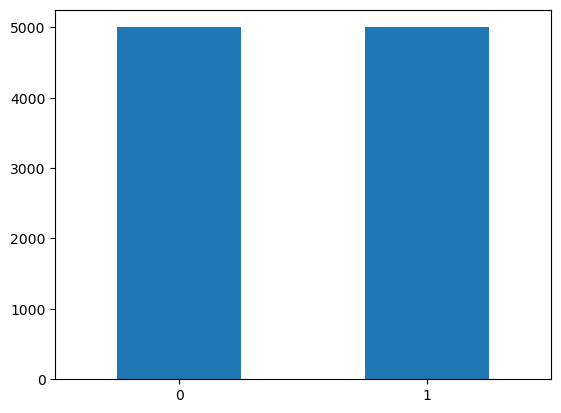

In [28]:
pd.Series(y_train2).value_counts().sort_index().plot(kind='bar', rot=0);

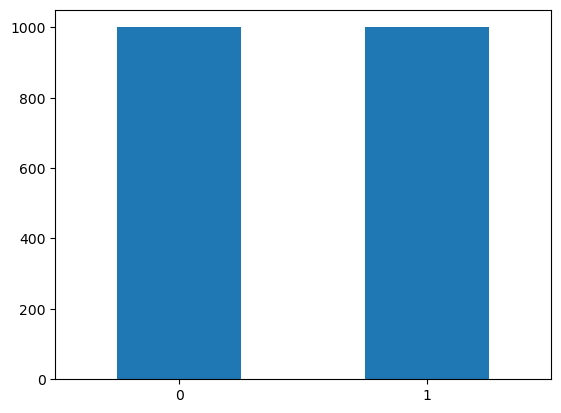

In [29]:
pd.Series(y_test2).value_counts().sort_index().plot(kind='bar', rot=0);

In [6]:
# svms_b_acc = []

def train_test_svm(model,X_train,X_test,y_train,y_test):
    start_time = time.time()
    
    model.fit(X_train,y_train)

    y_pred = model.predict(X_test)

    end_time=time.time()

    b_acc = balanced_accuracy_score(y_test,y_pred)

    print(f"Total time: {(end_time-start_time):.2f}s | Test Balanced accuracy: {round(b_acc*100,2):.2f}%")

    return round(b_acc*100,2)






In [31]:
svm_v0 = SVC()
b_acc = train_test_svm(svm_v0,X_train_pca,X_test_pca,y_train,y_test)


print(f"SVMv1 balanced accuracy: {b_acc}")


Total time: 490.3570101261139
SVMv1 balanced accuracy: 53.84


# IT TAKES TO MUCH TIME. SO FROM NOW ON I WILL WORK WITH ONLY 2 CLASSES

In [8]:
svm_v1 = SVC()
b_acc = train_test_svm(svm_v1,X_train2_sc_pca,X_test2_sc_pca,y_train2,y_test2)


Total time: 11.13s | Test Balanced accuracy: 90.60%


In [21]:
# A low C encourages a simpler model with a wider margin but may lead to some misclassifications.
# A high C tries to classify all training points correctly, potentially causing overfitting

# Small coef0: Focuses on higher-degree polynomial terms, capturing more complex relationships in data.
# Large coef0: Gives more importance to lower-degree terms, leading to simpler decision boundaries.

# Small gamma values: A wide influence, resulting in a smoother decision boundary (underfitting risk).
# Large gamma values: A narrow influence, allowing the model to fit more details (overfitting risk).

param_grid={
    "kernel":["poly"],
    "degree":[2], 
    "gamma":[0.001,0.01,0.1,1],
    "C":[0.1,1,10],   #
    "coef0":[0,1,10]
}

grid_search = GridSearchCV(SVC(),param_grid,cv=3,scoring="balanced_accuracy",n_jobs=-1,verbose=2)

grid_search.fit(X_train2_sc_pca,y_train2)

print(f"\nBest parameters: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_




y_pred2_best = best_svm.predict(X_test2_sc_pca)
best_acc = balanced_accuracy_score(y_test2,y_pred2_best)
print(f"best balanced accuracy: {round(best_acc*100,2)}%")

# svm_v2 = SVC(kernel='poly',degree=2)
# b_acc = train_test_svm(svm_v2,X_train2_sc_pca,X_test2_sc_pca,y_train2,y_test2)


Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best parameters: {'C': 1, 'coef0': 10, 'degree': 2, 'gamma': 0.01, 'kernel': 'poly'}
best balanced accuracy: 90.9%


In [24]:
# When to Use the RBF Kernel
# Nonlinear Problems: When the relationship between features and classes is not linear.
# High-Dimensional Data: RBF works well even when the number of features is much larger than the number of samples.

param_grid = {
    "C": [0.1, 1, 10, 100, 200],  # Regularization parameter
    "gamma": [0.001, 0.01, 0.1, 1],  # RBF kernel parameter
    "kernel": ["rbf"]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring="balanced_accuracy", verbose=3, n_jobs=-1)

grid_search.fit(X_train2_sc_pca,y_train2)

print(f"\nBest parameters: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_


y_pred2_best = best_svm.predict(X_test2_sc_pca)
best_acc = balanced_accuracy_score(y_test2,y_pred2_best)
print(f"best balanced accuracy: {round(best_acc*100,2)}%")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
best balanced accuracy: 90.7%


In [26]:
# When to Use the Linear Kernel

# Linearly Separable Data: Works well if the classes can be separated with a straight line or a hyperplane.
# High-Dimensional Data: Performs well in cases where the number of features is very large (e.g., text classification, where features are word counts or embeddings).
# Efficiency: Faster to compute compared to non-linear kernels (like RBF or polynomial), as it avoids complex transformations.
# Low Noise: Best suited for datasets with less noise or overlap between classes.

param_grid = {
    "kernel":["linear"],
    "C": [0.1, 1, 10, 100]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring="balanced_accuracy", verbose=3, n_jobs=-1)

grid_search.fit(X_train2_sc_pca,y_train2)

print(f"\nBest parameters: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_


y_pred2_best = best_svm.predict(X_test2_sc_pca)
best_acc = balanced_accuracy_score(y_test2,y_pred2_best)
print(f"best balanced accuracy: {round(best_acc*100,2)}%")

Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters: {'C': 1, 'kernel': 'linear'}
best balanced accuracy: 82.75%


# FROM THE ABOVE I SEE THAT THE BEST CHOISES PROBABLY ARE POLY AND RBF. BELOW I WILL TAKE THE 10 CLASSES

In [14]:
svm_rbf_v1 = SVC(kernel = "rbf",C=10,gamma=0.1)

#wrap it with OneVsRestClassifier
ovr_class_v1 = OneVsRestClassifier(svm_rbf_v1,n_jobs=-1)

train_test_svm(ovr_class_v1,X_train_sc_pca,X_test_sc_pca,y_train,y_test)



KeyboardInterrupt: 

## SO THE ONEVSREST APPROACH TOOK TOO MUCH TIME. I WILL TRY THE ONEVSONE APPROCH NOW

In [ ]:
svm_ovo_v1 = SVC(kernel = "rbf",C=10,gamma=0.1)

train_test_svm(svm_ovo_v1,X_train_sc_pca,X_test_sc_pca,y_train,y_test)

#THIS TOOK TOO MUCH TIME

In [19]:
import numpy as np
from sklearn.metrics import pairwise as sklearn_pairwise

def reduce_dataset_representative(X, y, num_samples_per_class):
    """
    Reduces the dataset by selecting samples closest to the average per class.
    
    Args:
        X: Feature matrix (num_samples, num_features).
        y: Labels (num_samples,).
        num_samples_per_class: Desired number of samples per class.

    Returns:
        X_reduced, y_reduced: Reduced feature matrix and labels, shuffled.
    """
    X = np.array(X)
    y = np.array(y)
    unique_classes = np.unique(y)
    X_reduced, y_reduced = [], []

    for cls in unique_classes:
        # Get samples belonging to this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        
        # Compute the average sample for the class
        avg_sample = np.mean(X_cls, axis=0, keepdims=True)
        
        # Compute distances of all samples to the average sample
        distances = sklearn_pairwise.euclidean_distances(X_cls, avg_sample).flatten()
        
        # Get indices of the closest samples
        representative_indices = np.argsort(distances)[:num_samples_per_class]
        
        # Select these samples
        X_reduced.append(X_cls[representative_indices])
        y_reduced.append(y_cls[representative_indices])
    
    # Combine all reduced samples
    X_reduced = np.vstack(X_reduced)
    y_reduced = np.hstack(y_reduced)

    # Shuffle the combined data while keeping the pairs intact
    indices = np.random.permutation(X_reduced.shape[0])
    X_reduced = X_reduced[indices]
    y_reduced = y_reduced[indices]
    
    return X_reduced, y_reduced


In [20]:
X_train_reduced,y_train_reduced = reduce_dataset_representative(X_train_sc_pca,y_train,2500)

X_train_reduced.shape, y_train_reduced.shape

((25000, 131), (25000,))

In [23]:
y_train_reduced

array([6, 3, 7, ..., 9, 7, 1])

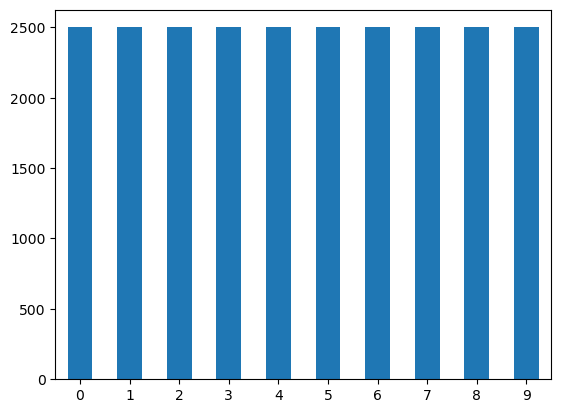

In [22]:
pd.Series(y_train_reduced).value_counts().sort_index().plot(kind='bar', rot=0);

In [ ]:
#X_test_reduced,y_test_reduced = reduce_dataset_representative(X_test_sc_pca,y_test,200)

#X_test_reduced.shape, y_test_reduced.shape

In [24]:
svm_ovo_v1 = SVC(kernel = "rbf",C=10,gamma=0.1)

train_test_svm(svm_ovo_v1,X_train_reduced,X_test_sc_pca,y_train_reduced,y_test)

Total time: 207.84s | Test Balanced accuracy: 17.81%


17.81

## NOW I WILL TRY TO GET A COMBINATION 

In [25]:
import numpy as np
from sklearn.metrics import pairwise as sklearn_pairwise

def reduce_dataset_combined(X, y, num_samples_per_class):
    """
    Reduces the dataset by selecting a mix of representative and diverse samples.
    
    Args:
        X: Feature matrix (num_samples, num_features).
        y: Labels (num_samples,).
        num_samples_per_class: Desired number of samples per class.

    Returns:
        X_reduced, y_reduced: Reduced feature matrix and labels, shuffled.
    """
    X = np.array(X)
    y = np.array(y)
    unique_classes = np.unique(y)
    X_reduced, y_reduced = [], []
    rep_ratio = 0.8  # 80% representative, 20% diverse

    for cls in unique_classes:
        # Get samples belonging to this class
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        
        # Compute the average sample for the class
        avg_sample = np.mean(X_cls, axis=0, keepdims=True)
        
        # Compute distances of all samples to the average sample
        distances = sklearn_pairwise.euclidean_distances(X_cls, avg_sample).flatten()
        
        # Split indices into representative and diverse
        num_representative = int(rep_ratio * num_samples_per_class)
        num_diverse = num_samples_per_class - num_representative

        representative_indices = np.argsort(distances)[:num_representative]
        diverse_indices = np.argsort(distances)[-num_diverse:]
        
        # Combine selected samples
        selected_indices = np.concatenate((representative_indices, diverse_indices))
        
        X_reduced.append(X_cls[selected_indices])
        y_reduced.append(y_cls[selected_indices])
    
    # Combine all reduced samples
    X_reduced = np.vstack(X_reduced)
    y_reduced = np.hstack(y_reduced)
    
    # Shuffle the combined data while keeping the pairs intact
    indices = np.random.permutation(X_reduced.shape[0])
    X_reduced = X_reduced[indices]
    y_reduced = y_reduced[indices]
    
    return X_reduced, y_reduced


In [26]:
X_train_reduced_combined,y_train_reduced_combined = reduce_dataset_combined(X_train_sc_pca,y_train,2500)

X_train_reduced_combined.shape, y_train_reduced_combined.shape

((25000, 131), (25000,))

In [ ]:
train_test_svm(SVC(),X_train_reduced_combined,X_test_sc_pca,y_train_reduced_combined,y_test)

In [31]:
# Define the parameter distribution
param_dist = {
    'C': [0.01,0.1,1,10],  # Values for C from 0.001 to 1000
    "gamma": [0.01, 0.1, 1],
    'degree': [2, 3, 4],  # Degree only for poly kernel
    'kernel': ['poly', 'rbf']  # Kernels to test
}

# Initialize the SVM
svm = SVC()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    n_iter=50,  # Number of different combinations to try
    cv=3,  # 3-fold cross-validation
    scoring='balanced_accuracy',  # Metric to optimize
    n_jobs=-1,  # Use all available cores
    verbose=3
)

# Fit the model
random_search.fit(X_train_reduced_combined, y_train_reduced_combined)

# Print the best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validated accuracy: {random_search.best_score_:.4f}")

# To use the best estimator
best_svm = random_search.best_estimator_


Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
param_grid={
    "kernel":["poly","rbf"],
    "degree":[2,3,4], 
}

grid_search = GridSearchCV(SVC(),param_grid,cv=3,scoring=balanced_accuracy_score,n_jobs=-1,verbose=4, return_train_score=True)

grid_search.fit(X_train,y_train)

print(f"\nBest parameters: {grid_search.best_params_}")

best_svm = grid_search.best_estimator_




y_pred_best = best_svm.predict(X_test)
best_acc = balanced_accuracy_score(y_test,y_pred_best)
print(f"best balanced accuracy: {best_acc}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(
C:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the train scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(



Best parameters: {'degree': 2, 'kernel': 'poly'}


PCA AND STANDARD SCALE THE X

- The maximum margin classifier forms the basis of SVMs, searating classes with the widest posssible gap to ensure stability and robustness.
This stability under perturbations makes it a <u>**powerful choice**</u> for tasks where <u>**small changes in data are common**</u>

- SVMs are by definition two-class classifiers.

- In scenarios where the number of classes (c > 2), Support Vector Machines (SVMs) can be extended to handle multiclass classification using two common approaches:
1. One-vs-the-Rest Approach
Train one SVM model for each class. For class i, the SVM distinguishes between class i and all other classes.

2. One-vs-One Approach
Train c(c-1)/2 binary SVM models, each for a pair of classes (one-vs-one).
For a given input the predicted class is determined by **majority voting**, i.e., the class that receives the highest number of "votes" across all pairwise models is selected.


# AN DO OTI PAIRNIE POLY ORA NA TREJEI MPORO NA KRATISO MONO 2 CLASSES ETSI OSTE NA TREXEI PIO GRIGORA KAI NA DOKIIMAZO PERISSOTERA PRAGMATA